In [1]:
from typing import TypedDict, Annotated
from dotenv import load_dotenv, find_dotenv
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import create_react_agent
from langmem import create_manage_memory_tool, create_search_memory_tool

In [2]:
%%writefile ../src/email_assistant/prompts.py
# Agent prompt baseline 
agent_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

# Agent prompt semantic memory
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory("email_assistant", user, "collection") - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. manage_memory("email_assistant", user, "user_profile") - Store any relevant information about the recipient, {name}, in the user profile for future reference the current user profile is shown below
6. search_memory("email_assistant", user, "collection") - Search memory for detail from previous emails
7. manage_memory("email_assistant", user, "instructions") - Update the instructions for agent tool usage based upon the user feedback 
</ Tools >

< User profile >
{profile}
</ User profile >

< Instructions >
{instructions}
</ Instructions >
"""

# Triage prompt
triage_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}. 
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >
{examples}
</ Few shot examples >
"""

triage_user_prompt = """
Please determine how to handle the below email thread:

From: {author}
To: {to}
Subject: {subject}
{email_thread}"""


Overwriting ../src/email_assistant/prompts.py


In [3]:
from pydantic import BaseModel, Field
from typing import Literal

class Classify(BaseModel):
    """Analyzed the unreead email and classify it according to it contents."""
    description: str = Field(description="step by step reasoning behind choosing the classification")
    classification: Literal["ignore", "notify", "respond"] = Field(
        description="The classification of the email there are only 3 possible class:" \
        "1. ignore: for irrelevant emails that does not need a response" \
        "2. notify: for important emails that doesn't need a response" \
        "3. respond: for important emails that also needs to be replied and attended to.")


In [4]:
_ = load_dotenv(find_dotenv())


llm = init_chat_model("openai:gpt-4o-mini")

In [5]:
llm_structured_outut =llm.with_structured_output(Classify)
llm_structured_outut

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x741f067b9f40>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x741f05f58110>, root_client=<openai.OpenAI object at 0x741f075ff890>, root_async_client=<openai.AsyncOpenAI object at 0x741f0604f5f0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'response_format': <class '__main__.Classify'>, 'ls_structured_output_format': {'kwargs': {'method': 'json_schema', 'strict': None}, 'schema': {'type': 'function', 'function': {'name': 'Classify', 'description': 'Analyzed the unreead email and classify it according to it contents.', 'parameters': {'properties': {'description': {'description': 'step by step reasoning behind choosing the classification', 'type': 'string'}, 'classification': {'description': "The classification of the email there are only 3 possible class:1. ignore: for irrelevant emails th

In [6]:
user_profile = {
    "name": "Nnaemeka",
    "full_name": "Nnaemeka Nwankwo",
    "user_profile_background": "AI engineer. creating solutions with a AI agent leading a team of 3"
}

prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage Nnaemeka's tasks efficiently."
}

# Example incoming email
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi Nnaemeka,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [7]:
from email_assistant.prompts import triage_system_prompt, triage_user_prompt, agent_system_prompt, agent_system_prompt_memory
system_prompt = triage_system_prompt.format(
    full_name=user_profile["full_name"],
    name=user_profile["name"],
    examples=None,
    user_profile_background=user_profile["user_profile_background"],
    triage_no=prompt_instructions["triage_rules"]["ignore"],
    triage_notify=prompt_instructions["triage_rules"]["notify"],
    triage_email=prompt_instructions["triage_rules"]["respond"],
)

In [8]:
user_prompt = triage_user_prompt.format(
    author=email["from"],
    to=email["to"],
    subject=email["subject"],
    email_thread=email["body"],
)
user_prompt

"\nPlease determine how to handle the below email thread:\n\nFrom: Alice Smith <alice.smith@company.com>\nTo: Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>\nSubject: Quick question about API documentation\n\nHi Nnaemeka,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"

In [9]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

result = llm_structured_outut.invoke(
    [
        SystemMessage(content = system_prompt),
        HumanMessage(content=user_prompt),
    ]
)

In [10]:
result

Classify(description='The email is from a team member (Alice) asking a direct question regarding the API documentation, specifically about missing endpoints. This requires clarification from Nnaemeka regarding whether the omissions were intentional or if updates are needed. Since it involves a direct inquiry that necessitates a response from Nnaemeka, it falls under the classification of needing a direct response.', classification='respond')

In [11]:
print(result.description)
print(result.classification)

The email is from a team member (Alice) asking a direct question regarding the API documentation, specifically about missing endpoints. This requires clarification from Nnaemeka regarding whether the omissions were intentional or if updates are needed. Since it involves a direct inquiry that necessitates a response from Nnaemeka, it falls under the classification of needing a direct response.
respond


In [12]:
# Create dummy agent tools for testing
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees for a duration of {duration_minutes}"


@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"


In [13]:
def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt.format(
                instructions=prompt_instructions["agent_instructions"],
                **user_profile
                )
        }
    ] + state['messages']

In [14]:
tools = [write_email, check_calendar_availability, schedule_meeting]

agent = create_react_agent(
    "openai:gpt-4o",
    tools=tools,
    prompt=create_prompt,
)

In [15]:
response = agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "what is my availability for tuesday?"
    }]}
)

In [16]:
response

{'messages': [HumanMessage(content='what is my availability for tuesday?', additional_kwargs={}, response_metadata={}, id='dd40a892-690b-48dd-876e-4b5e2ccdcfbe'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UwXM240b8zR6kDMCX5natNwC', 'function': {'arguments': '{"day":"2023-10-24"}', 'name': 'check_calendar_availability'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 258, 'total_tokens': 279, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BuldfVWXQzo3zwZCLamsRoOuoVz6P', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6a86e534-7588-458a-beae-0e5d63b680b3-0', tool_calls=[{'name': 'check_calendar_availability',

In [17]:

response["messages"][-1].pretty_print()

================================== Ai Message ==================================

You have availability on Tuesday, October 24th, at the following times:

- 9:00 AM
- 2:00 PM
- 4:00 PM


In [18]:
from langgraph.graph import add_messages
class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [19]:
from langgraph.types import Command
from IPython.display import Image, display

In [20]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=user_profile["full_name"],
        name=user_profile["name"],
        user_profile_background=user_profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_structured_outut.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

In [21]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile()

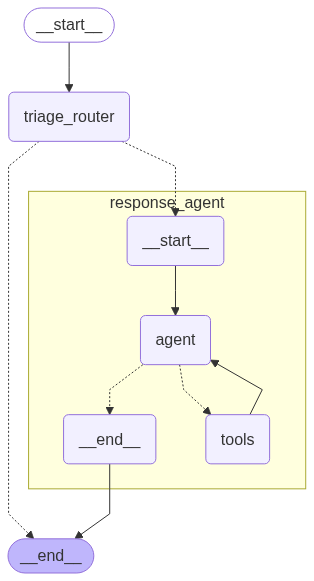

In [22]:
# Show the agent
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [23]:
email_input = {
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "email_thread": """Dear Valued Developer,

Don't miss out on this INCREDIBLE opportunity! 

🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite! 

✨ FEATURES:
- Revolutionary AI-powered code completion
- Cloud-based development environment
- 24/7 customer support
- And much more!

💰 Regular Price: $999/month
🎉 YOUR SPECIAL PRICE: Just $199/month!

🕒 Hurry! This offer expires in:
24 HOURS ONLY!

Click here to claim your discount: https://amazingdeals.com/special-offer

Best regards,
Marketing Team
---
To unsubscribe, click here
""",
}

In [24]:
response = email_agent.invoke({"email_input": email_input})

Task triage_router with path ('__pregel_pull', 'triage_router') wrote to unknown channel branch:to:__end__, ignoring it.


🚫 Classification: IGNORE - This email can be safely ignored


In [25]:
email_input = {
    "author": "Lang Smith <lang.smith@company.com>",
    "to": "Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [26]:
response = email_agent.invoke({"email_input": email_input}, )

📧 Classification: RESPOND - This email requires a response


In [27]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Lang Smith <lang.smith@company.com>', 'to': 'Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_8xoSUfihyg9nRGDWrMOo6jv7)
 Call ID: call_8xoSUfihyg9nRGDWrMOo6jv7
  Args:
    to: lang.smith@company.com
    subject: Re: Quick question about API documentation
    content: Hi Lang,

Thank you for reaching out regarding the API documentation. The endpoints /auth/refresh and /auth/validate 

In [28]:
# I want to enable thread conversations and and also for a certain user enable user behavior across threads.
from uuid import uuid4
thread_id = str(uuid4()) # to enable threads
user_id = "emeka" # to enable separate users


# create store
from langgraph.store.memory import InMemoryStore
store = InMemoryStore(index={"embed": "openai:text-embedding-3-small"})


In [29]:
data = {
    "email": email_input,
    "label": "respond"

}

store.put(namespace=("email_assistant", user_id, "example"),
          key = str(uuid4()),
          value= data,
          )


In [30]:
data = {
    "email": {
        "author": "Sarah Chen <sarah.chen@company.com>",
        "to": "Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>",
        "subject": "Update: Backend API Changes Deployed to Staging",
        "email_thread": """Hi John,
    
    Just wanted to let you know that I've deployed the new authentication endpoints we discussed to the staging environment. Key changes include:
    
    - Implemented JWT refresh token rotation
    - Added rate limiting for login attempts
    - Updated API documentation with new endpoints
    
    All tests are passing and the changes are ready for review. You can test it out at staging-api.company.com/auth/*
    
    No immediate action needed from your side - just keeping you in the loop since this affects the systems you're working on.
    
    Best regards,
    Sarah
    """,
    },
    "label": "ignore"
}

store.put(
    ("email_assistant", user_id, "examples"),
    str(uuid4()),
    data
)

In [31]:
# Template for formating an example to put in prompt
template = """Email Subject: {subject}
Email From: {from_email}
Email To: {to_email}
Email Content: 
```
{content}
```
> Triage Result: {result}"""

# Format list of few shots
def format_few_shot_examples(examples):
    strs = ["Here are some previous examples:"]
    for eg in examples:
        strs.append(
            template.format(
                subject=eg.value["email"]["subject"],
                to_email=eg.value["email"]["to"],
                from_email=eg.value["email"]["author"],
                content=eg.value["email"]["email_thread"][:400],
                result=eg.value["label"],
            )
        )
    return "\n\n------------\n\n".join(strs)

In [32]:
email_data = {
        "author": "Sarah Chen <sarah.chen@company.com>",
        "to": "Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>",
        "subject": "Update: Backend API Changes Deployed to Staging",
        "email_thread": """Hi John,
    
    Wanted to let you know that I've deployed the new authentication endpoints we discussed to the staging environment. Key changes include:
    
    - Implemented JWT refresh token rotation
    - Added rate limiting for login attempts
    - Updated API documentation with new endpoints
    
    All tests are passing and the changes are ready for review. You can test it out at staging-api.company.com/auth/*
    
    No immediate action needed from your side - just keeping you in the loop since this affects the systems you're working on.
    
    Best regards,
    Sarah
    """,
    }
results = store.search(
    ("email_assistant", user_id, "examples"),
    query=str({"email": email_data}),
    limit=1)

In [33]:
format_few_shot_examples(results)

"Here are some previous examples:\n\n------------\n\nEmail Subject: Update: Backend API Changes Deployed to Staging\nEmail From: Sarah Chen <sarah.chen@company.com>\nEmail To: Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>\nEmail Content: \n```\nHi John,\n\n    Just wanted to let you know that I've deployed the new authentication endpoints we discussed to the staging environment. Key changes include:\n\n    - Implemented JWT refresh token rotation\n    - Added rate limiting for login attempts\n    - Updated API documentation with new endpoints\n\n    All tests are passing and the changes are ready for review. You can test it out at staging-api.co\n```\n> Triage Result: ignore"

In [35]:
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant", 
        "{langgraph_user_id}",
        "collection"
    )
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

In [36]:
def triage_router(state: State, config, store) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    namespace = (
        "email_assistant",
        config['configurable']['langgraph_user_id'],
        "examples"
    )
    examples = store.search(
        namespace, 
        query=str({"email": state['email_input']})
    ) 
    examples=format_few_shot_examples(examples)

    langgraph_user_id = config['configurable']['langgraph_user_id']
    namespace = (langgraph_user_id, )

    result = store.get(namespace, "triage_ignore")
    if result is None:
        store.put(
            namespace, 
            "triage_ignore", 
            {"prompt": prompt_instructions["triage_rules"]["ignore"]}
        )
        ignore_prompt = prompt_instructions["triage_rules"]["ignore"]
    else:
        ignore_prompt = result.value['prompt']

    result = store.get(namespace, "triage_notify")
    if result is None:
        store.put(
            namespace, 
            "triage_notify", 
            {"prompt": prompt_instructions["triage_rules"]["notify"]}
        )
        notify_prompt = prompt_instructions["triage_rules"]["notify"]
    else:
        notify_prompt = result.value['prompt']

    result = store.get(namespace, "triage_respond")
    if result is None:
        store.put(
            namespace, 
            "triage_respond", 
            {"prompt": prompt_instructions["triage_rules"]["respond"]}
        )
        respond_prompt = prompt_instructions["triage_rules"]["respond"]
    else:
        respond_prompt = result.value['prompt']
    
    system_prompt = triage_system_prompt.format(
        full_name=user_profile["full_name"],
        name=user_profile["name"],
        user_profile_background=user_profile["user_profile_background"],
        triage_no=ignore_prompt,
        triage_notify=notify_prompt,
        triage_email=respond_prompt,
        examples=examples
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_structured_outut.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

In [37]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

In [38]:
def create_prompt(state, config, store):
    langgraph_user_id = config['configurable']['langgraph_user_id']
    namespace = (langgraph_user_id, )
    result = store.get(namespace, "agent_instructions")
    if result is None:
        store.put(
            namespace, 
            "agent_instructions", 
            {"prompt": prompt_instructions["agent_instructions"]}
        )
        prompt = prompt_instructions["agent_instructions"]
    else:
        prompt = result.value['prompt']
    
    return [
        {
            "role": "system", 
            "content": agent_system_prompt_memory.format(
                instructions=prompt, 
                **user_profile
            )
        }
    ] + state['messages']

In [39]:
tools = [
    write_email,
    schedule_meeting,
    check_calendar_availability,
    search_memory_tool,
    manage_memory_tool,
]

agent = create_react_agent(
    "openai:gpt-4o",
    tools,
    prompt=create_prompt,
    store=store,
)

In [40]:
from langgraph.checkpoint.memory import InMemorySaver
# We need this because we want to enable threads (conversations)
checkpointer = InMemorySaver()


In [41]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(checkpointer, store=store)

In [42]:
config = {
    "configurable": {"thread_id": thread_id, "langgraph_user_id": user_id}
}

In [43]:
email_input = {
    "author": "Alice Jones <alice.jones@bar.com>",
    "to": "Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

Urgent issue - your service is down. Is there a reason why""",
}

In [44]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [45]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Jones <alice.jones@bar.com>', 'to': 'Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': 'Hi John,\n\nUrgent issue - your service is down. Is there a reason why'}
================================== Ai Message ==================================
Tool Calls:
  search_memory (call_8abRqXU1gOy9sxl6IH8ogh3S)
 Call ID: call_8abRqXU1gOy9sxl6IH8ogh3S
  Args:
    query: Alice Jones
    limit: 5
================================= Tool Message =================================
Name: search_memory

[]
================================== Ai Message ==================================
Tool Calls:
  write_email (call_rjfY65Ipn8zH5QYBT6OqlvEL)
 Call ID: call_rjfY65Ipn8zH5QYBT6OqlvEL
  Args:
    to: alice.jones@bar.com
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thank you for reaching o

In [47]:
store.get(("emeka",), "agent_instructions" ).value['prompt']

"Use these tools when appropriate to help manage John's tasks efficiently."

In [48]:
store.get(("emeka",), "triage_respond").value['prompt']

'Direct questions from team members, meeting requests, critical bug reports'

In [49]:
store.get(("emeka",), "triage_ignore").value['prompt']

'Marketing newsletters, spam emails, mass company announcements'

In [50]:
store.get(("emeka",), "triage_notify").value['prompt']

'Team member out sick, build system notifications, project status updates'

In [51]:
from langmem import create_multi_prompt_optimizer

In [52]:
conversations = [
    (
        response['messages'],
        "Always sign your emails `Nnaemeka Nwankwo\nMachine learning Engineer`"
    )
]

In [59]:
optimizer = create_multi_prompt_optimizer(
    "openai:gpt-4o",
    kind="prompt_memory",
)

In [56]:
prompts = [
    {
        "name": "main_agent",
        "prompt": store.get(("emeka",), "agent_instructions").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on how the agent should do only these two things 1. write emails 2.schedule events"
        
    },
    {
        "name": "triage-ignore", 
        "prompt": store.get(("emeka",), "triage_ignore").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be ignored"

    },
    {
        "name": "triage-notify", 
        "prompt": store.get(("emeka",), "triage_notify").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails the user should be notified of"

    },
    {
        "name": "triage-respond", 
        "prompt": store.get(("emeka",), "triage_respond").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be responded to"

    },
]

In [60]:
updated_mem = optimizer.invoke(
    {"trajectories": conversations, "prompts": prompts}
)

print(updated_mem)

[{'name': 'main_agent', 'prompt': "Use these tools when appropriate to help manage John's tasks efficiently. Always sign emails with 'John Doe'.", 'update_instructions': 'keep the instructions short and to the point', 'when_to_update': 'Update this prompt whenever there is feedback on how the agent should write emails or schedule events'}, {'name': 'triage-ignore', 'prompt': 'Marketing newsletters, spam emails, mass company announcements', 'update_instructions': 'keep the instructions short and to the point', 'when_to_update': 'Update this prompt whenever there is feedback on which emails should be ignored'}, {'name': 'triage-notify', 'prompt': 'Team member out sick, build system notifications, project status updates', 'update_instructions': 'keep the instructions short and to the point', 'when_to_update': 'Update this prompt whenever there is feedback on which emails the user should be notified of'}, {'name': 'triage-respond', 'prompt': 'Direct questions from team members, meeting req

In [61]:
import json
print(json.dumps(updated_mem, indent=4))

[
    {
        "name": "main_agent",
        "prompt": "Use these tools when appropriate to help manage John's tasks efficiently. Always sign emails with 'John Doe'.",
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on how the agent should write emails or schedule events"
    },
    {
        "name": "triage-ignore",
        "prompt": "Marketing newsletters, spam emails, mass company announcements",
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be ignored"
    },
    {
        "name": "triage-notify",
        "prompt": "Team member out sick, build system notifications, project status updates",
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emai

In [69]:
# lets update the instructions in store
def update_mem_instructions(user_id: str, updated_mem, prompts, store):
    for i, updated_prompt in enumerate(updated_mem):
        old_prompt = prompts[i]
        if updated_prompt['prompt'] != old_prompt['prompt']:
            name = old_prompt['name']
            print(f"updated {name}")
            if name == "main_agent":
                store.put(
                    (user_id,),
                    "agent_instructions",
                    {"prompt":updated_prompt['prompt']}
                )
                print(f"Encountered {name}, implement the remaining stores!")
            elif name == "triage-ignore":
                store.put(
                    (user_id,),
                    "triage_ignore",
                    {"prompt":updated_prompt['prompt']}
                )
                print(f"Encountered {name}, implement the remaining stores!")
            elif name == "triage-notify":
                store.put(
                    (user_id,),
                    "triage_notify",
                    {"prompt":updated_prompt['prompt']}
                )
                print(f"Encountered {name}, implement the remaining stores!")
            elif name == "triage-respond":
                store.put(
                    (user_id,),
                    "triage_respond",
                    {"prompt":updated_prompt['prompt']}
                )
                print(f"Encountered {name}, implement the remaining stores!")
            else:
                #raise ValueError
                print(f"Encountered No update!")

In [68]:
update_mem_instructions("emeka", updated_mem, prompts, store)

updated main_agent
Encountered main_agent, implement the remaining stores!


In [70]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [84]:
response["messages"]#[-1].pretty_print()

[HumanMessage(content="Respond to the email {'author': 'Alice Jones <alice.jones@bar.com>', 'to': 'Nnaemeka Nwankwo <nnaemeka.nwankwo@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': 'Hi John,\\n\\nUrgent issue - your service is down. Is there a reason why'}", additional_kwargs={}, response_metadata={}, id='e6f0347b-24c8-4079-8438-ba05eca2d006'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8abRqXU1gOy9sxl6IH8ogh3S', 'function': {'arguments': '{"query":"Alice Jones","limit":5}', 'name': 'search_memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 585, 'total_tokens': 604, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': '

In [72]:
conversations = [
    (
        response['messages'],
        "Ignore any emails from Alice Jones"
    )
]

In [73]:
updated_mem = optimizer.invoke(
    {"trajectories": conversations, "prompts": prompts}
)

print(updated_mem)

[{'name': 'main_agent', 'prompt': "Use these tools when appropriate to help manage John's tasks efficiently. Please ignore any emails from Alice Jones.", 'update_instructions': 'keep the instructions short and to the point', 'when_to_update': 'Update this prompt whenever there is feedback on how the agent should write emails or schedule events'}, {'name': 'triage-ignore', 'prompt': 'Marketing newsletters, spam emails, mass company announcements. Ignore any emails from Alice Jones.', 'update_instructions': 'keep the instructions short and to the point', 'when_to_update': 'Update this prompt whenever there is feedback on which emails should be ignored'}, {'name': 'triage-notify', 'prompt': 'Team member out sick, build system notifications, project status updates', 'update_instructions': 'keep the instructions short and to the point', 'when_to_update': 'Update this prompt whenever there is feedback on which emails the user should be notified of'}, {'name': 'triage-respond', 'prompt': 'Dir

In [74]:

print(json.dumps(updated_mem, indent=4))

[
    {
        "name": "main_agent",
        "prompt": "Use these tools when appropriate to help manage John's tasks efficiently. Please ignore any emails from Alice Jones.",
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on how the agent should write emails or schedule events"
    },
    {
        "name": "triage-ignore",
        "prompt": "Marketing newsletters, spam emails, mass company announcements. Ignore any emails from Alice Jones.",
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be ignored"
    },
    {
        "name": "triage-notify",
        "prompt": "Team member out sick, build system notifications, project status updates",
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this pro

In [75]:
update_mem_instructions("emeka", updated_mem, prompts, store)

updated main_agent
Encountered main_agent, implement the remaining stores!
updated triage-ignore
Encountered triage-ignore, implement the remaining stores!


In [85]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

Task triage_router with path ('__pregel_pull', 'triage_router') wrote to unknown channel branch:to:__end__, ignoring it.


🚫 Classification: IGNORE - This email can be safely ignored


In [86]:
store.get(("emeka",), "triage_ignore").value['prompt']

'Marketing newsletters, spam emails, mass company announcements. Ignore any emails from Alice Jones.'

In [ ]:
# adding human in the loop we can add it dyanmically or statically I will go with dynamic interrupt

In [87]:
@tool
class Question(BaseModel):
    """Question to ask the user."""
    content: str
@ tool
class Done(BaseModel):
    """When E-mail has been sent"""
    done: bool
    

In [ ]:
def triage_router(state: State, config, store) -> Command[
    Literal["triage_interrupt_handler","response_agent", "__end__"]
]:
    # Parse email
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    #create namespace for memory 
    namespace = (
        "email_assistant",
        config['configurable']['langgraph_user_id'],
        "examples"
    )
    # semantic search for name the namespace
    examples = store.search(
        namespace, 
        query=str({"email": state['email_input']})
    ) 
    # format examples if available
    examples=format_few_shot_examples(examples)

    # get the user ID
    langgraph_user_id = config['configurable']['langgraph_user_id']
    namespace = (langgraph_user_id, )

    # episodic memory 
    result = store.get(namespace, "triage_ignore")
    if result is None:
        store.put(
            namespace, 
            "triage_ignore", 
            {"prompt": prompt_instructions["triage_rules"]["ignore"]}
        )
        ignore_prompt = prompt_instructions["triage_rules"]["ignore"]
    else:
        ignore_prompt = result.value['prompt']

    result = store.get(namespace, "triage_notify")
    if result is None:
        store.put(
            namespace, 
            "triage_notify", 
            {"prompt": prompt_instructions["triage_rules"]["notify"]}
        )
        notify_prompt = prompt_instructions["triage_rules"]["notify"]
    else:
        notify_prompt = result.value['prompt']

    result = store.get(namespace, "triage_respond")
    if result is None:
        store.put(
            namespace, 
            "triage_respond", 
            {"prompt": prompt_instructions["triage_rules"]["respond"]}
        )
        respond_prompt = prompt_instructions["triage_rules"]["respond"]
    else:
        respond_prompt = result.value['prompt']
    
    system_prompt = triage_system_prompt.format(
        full_name=user_profile["full_name"],
        name=user_profile["name"],
        user_profile_background=user_profile["user_profile_background"],
        triage_no=ignore_prompt,
        triage_notify=notify_prompt,
        triage_email=respond_prompt,
        examples=examples
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_structured_outut.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "classification_decision": result.classification
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update ={
            "classification_decision": result.classification
        }
        goto = "triage_interrupt_handler"
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

In [ ]:
def format_email(subject, author, to, email_thread, email_id=None):
    """Format email details into a nicely formatted markdown string for display
    
    Args:
        subject: Email subject
        author: Email sender
        to: Email recipient
        email_thread: Email content
        email_id: Optional email ID (for Gmail API)
    """
    id_section = f"\n**ID**: {email_id}" if email_id else ""
    
    return f"""

        **Subject**: {subject}
        **From**: {author}
        **To**: {to}{id_section}
        
        {email_thread}
        
        ---
        """

In [ ]:
from langgraph.types import interrupt, Command

def traige_interrupt_handler(state: State)-> Command[
    Literal["response_agent", "__end__"]
    ]:
    # Parse email
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    formatted_email = format_email(subject, author, to, email_thread, email_id=None)
    # Create interrupt that is shown to the user
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True, 
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description":formatted_email,
    }
    # Agent Inbox responds with a list of dicts with a single key `type` that can be `accept`, `edit`, `ignore`, or `response`.  
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        # Used by the response agent
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # Go to response agent
        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

In [ ]:
from langgraph.graph import MessagesState

# This state class extends the MessagesState
class NotifyState(MessagesState):
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

In [ ]:
# Email assistant with HITL prompt 
from datetime import datetime
agent_system_prompt_hitl = """
< Role >
You are a top-notch executive assistant who cares about helping your executive perform as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage communications and schedule:
{tools_prompt}
</ Tools >

< Instructions >
When handling emails, follow these steps:
1. Carefully analyze the email content and purpose
2. IMPORTANT --- always call a tool and call one tool at a time until the task is complete: 
3. If the incoming email asks the user a direct question and you do not have context to answer the question, use the Question tool to ask the user for the answer
4. For responding to the email, draft a response email with the write_email tool
5. For meeting requests, use the check_calendar_availability tool to find open time slots
6. To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter
   - Today's date is """ + datetime.now().strftime("%Y-%m-%d") + """ - use this for scheduling meetings accurately
7. If you scheduled a meeting, then draft a short response email using the write_email tool
8. After using the write_email tool, the task is complete
9. If you have sent the email, then use the Done tool to indicate that the task is complete
</ Instructions >

< Background >
{background}
</ Background >

< Response Preferences >
{response_preferences}
</ Response Preferences >

< Calendar Preferences >
{cal_preferences}
</ Calendar Preferences >
"""

In [ ]:
def create_notify_prompt(state:NotifyState, config, store):
    langgraph_user_id = config['configurable']['langgraph_user_id']
    namespace = (langgraph_user_id, )
    result = store.get(namespace, "agent_instructions")
    if result is None:
        store.put(
            namespace, 
            "agent_instructions", 
            {"prompt": prompt_instructions["agent_instructions"]}
        )
        prompt = prompt_instructions["agent_instructions"]
    else:
        prompt = result.value['prompt']
    
    return [
        {
            "role": "system", 
            "content": agent_system_prompt_memory.format(
                instructions=prompt, 
                **user_profile
            )
        }
    ] + state['messages']

In [ ]:
notify_tools = [
    write_email,
    schedule_meeting,
    check_calendar_availability,
    Question,
    Done,
]

llm_with_tools = llm.bind_tools(notify_tools, tool_choice="required")

def llm_call(state: State):
    """LLM decides whether to call a tool or not."""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    {"role": "system", "content": agent_system_prompt_hitl.format(tools_prompt=HITL_TOOLS_PROMPT, 
                                                                                  background=default_background,
                                                                                  response_preferences=default_response_preferences, 
                                                                                  cal_preferences=default_cal_preferences)}
                ]
                + state["messages"]
            )
        ]
    }

In [ ]:
def format_for_display(tool_call):
    """Format content for display in Agent Inbox
    
    Args:
        tool_call: The tool call to format
    """
    # Initialize empty display
    display = ""
    
    # Add tool call information
    if tool_call["name"] == "write_email":
        display += f"""# Email Draft

**To**: {tool_call["args"].get("to")}
**Subject**: {tool_call["args"].get("subject")}

{tool_call["args"].get("content")}
"""
    elif tool_call["name"] == "schedule_meeting":
        display += f"""# Calendar Invite

**Meeting**: {tool_call["args"].get("subject")}
**Attendees**: {', '.join(tool_call["args"].get("attendees"))}
**Duration**: {tool_call["args"].get("duration_minutes")} minutes
**Day**: {tool_call["args"].get("preferred_day")}
"""
    elif tool_call["name"] == "Question":
        # Special formatting for questions to make them clear
        display += f"""# Question for User

{tool_call["args"].get("content")}
"""
    else:
        # Generic format for other tools
        display += f"""# Tool Call: {tool_call["name"]}

Arguments:"""
        
        # Check if args is a dictionary or string
        if isinstance(tool_call["args"], dict):
            display += f"\n{json.dumps(tool_call['args'], indent=2)}\n"
        else:
            display += f"\n{tool_call['args']}\n"
    return display


In [ ]:
def interrupt_handler(state: State) -> Command[Literal["llm_call", "__end__"]]:
    """Creates an interrupt for human review of tool calls"""
    
    # Store messages
    result = []

    # Go to the LLM call node next
    goto = "llm_call"

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        
        # Allowed tools for HITL
        hitl_tools = ("write_email", "schedule_meeting", "Question")
        
        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute tool without interruption
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
            continue
            
        # Get original email from email_input in state
        author = state['email_input']['author']
        to = state['email_input']['to']
        subject = state['email_input']['subject']
        email_thread = state['email_input']['email_thread']
        email_input = format_email(subject, author, to, email_thread)
        
        # Format tool call for display and prepend the original email
        tool_display = format_for_display(tool_call)
        description = email_input + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {
                "action": tool_call["name"],
                "args": tool_call["args"]
            },
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the responses 
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
                        
        elif response["type"] == "edit":

            # Tool selection 
            tool = tools_by_name[tool_call["name"]]
            
            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Update the AI message's tool call with edited content (reference to the message in the state)
            ai_message = state["messages"][-1] # Get the most recent message from the state
            current_id = tool_call["id"] # Store the ID of the tool call being edited
            
            # Create a new list of tool calls by filtering out the one being edited and adding the updated version
            # This avoids modifying the original list directly (immutable approach)
            updated_tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
            ]
            
            # Create a new copy of the message with updated tool calls rather than modifying the original
            # This ensures state immutability and prevents side effects in other parts of the code
            # When we update the messages state key ("messages": result), the add_messages reducer will
            # overwrite existing messages by id and we take advantage of this here to update the tool calls.
            result.append(ai_message.model_copy(update={"tool_calls": updated_tool_calls}))

            # Update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})
            
            # Update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":
                
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})
            
            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this email draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this calendar meeting draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this question. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")
            
        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "Question": 
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User answered the question, which can we can use for any follow up actions. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Catch all other responses
        else:
            raise ValueError(f"Invalid response: {response}")
            
    # Update the state 
    update = {
        "messages": result,
    }

    return Command(goto=goto, update=update)

In [ ]:
from email_assistant.utils import show_graph
class StateInput(TypedDict):
    # This is the input to the state
    email_input: dict
    
# Conditional edge function
def should_continue(state: State) -> Literal["interrupt_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "interrupt_handler"

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("interrupt_handler", interrupt_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "interrupt_handler": "interrupt_handler",
        END: END,
    },
)

# Compile the agent
response_agent = agent_builder.compile()

# Build overall workflow
overall_workflow = (
    StateGraph(State, input=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
    
)
checkpointer = InMemorySaver()
email_agent = overall_workflow.compile()
# Show the agent
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until a tool call that we choose to interrupt
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
from langgraph.types import Command

print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

In [ ]:
# Same email as before
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with new thread
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_2 = uuid.uuid4()
thread_config_2 = {"configurable": {"thread_id": thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_2):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
# Now simulate user editing the schedule_meeting tool call
print("\nSimulating user editing the schedule_meeting tool call...")
edited_schedule_args = {
    "attendees": ["pm@client.com", "lance@company.com"],
    "subject": "Tax Planning Discussion",
    "duration_minutes": 30,  # Changed from 45 to 30
    "preferred_day": "2025-05-06",
    "start_time": 14 
}

for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_schedule_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
# Now simulate user editing the write_email tool call
print("\nSimulating user editing the write_email tool call...")
edited_email_args = {
    "to": "pm@client.com",
    "subject": "Re: Tax season let's schedule call",
    "content": "Hello Project Manager,\n\nThank you for reaching out about tax planning. I scheduled a 30-minute call next Thursday at 3:00 PM. Would that work for you?\n\nBest regards,\nLance Martin"
}

for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_email_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
state = graph.get_state(thread_config_2)
for m in state.values['messages']:
    m.pretty_print()

In [ ]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_5 = uuid.uuid4()
thread_config_5 = {"configurable": {"thread_id": thread_id_5}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm."}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Shorter and less formal. Include a closing statement about looking forward to the meeting!"}]), config=thread_config_5):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
state = graph.get_state(thread_config_5)
for m in state.values['messages']:
    m.pretty_print()

In [ ]:
# Respond
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Partner <partner@home.com>",
    "subject": "Dinner?",
    "email_thread": "Hey, do you want italian or indian tonight?"}

# Compile the graph
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_6 = uuid.uuid4()
thread_config_6 = {"configurable": {"thread_id": thread_id_6}}

# Run the graph until the first interrupt
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Let's do indian."}]), config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_6):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

In [ ]:
state = graph.get_state(thread_config_6)
for m in state.values['messages']:
    m.pretty_print()

In [ ]:
# Deployment
{
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}